This notebook provides a detailed walkthrough of the code implementation for DiffCoRank. For any query or to report any issue please contact the author: Anirban Chakraborty (chakra96@msu.edu)
--------

Library Imports
---------------
This section loads all the essential libraries required for the DiffCoRank implementation. These libraries support data handling, statistical computation, correlation analysis, clustering, dimensionality reduction, network analysis, and UMAP visualization. The list of libraries needed to run this package is given in the (requirement.txt) file. Make sure these packages are installed in your Python environment. You can install any missing ones using pip install.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
import pandas as pd
import numpy as np
import os
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from itertools import product
import warnings
import networkx as nx



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-

Loading Data
--------
In this section, we load the core input data files required for the DiffCoRank analysis. These datasets are read into Pandas DataFrames. These dataset are given in the Dataset folder in our Github Repository.

1. 'deseq2_rlog_normalized_counts.txt': Regularized log-transformed (rlog) normalized gene expression values, generated using DESeq2.

2. "deseq2_raw_counts.txt": Raw gene expression count matrix.

3. "samplesTableSeedless.csv": Sample metadata table (samplesTableSeedless.csv) containing condition labels and other annotations.

In [2]:
rlogCounts = pd.read_csv('deseq2_rlog_normalized_counts.txt', delimiter = "\t", index_col = 0)
counts = pd.read_csv("deseq2_raw_counts.txt", delimiter="\t", index_col=0)
sampleInfo = pd.read_csv("samplesTableSeedless.csv")

Filters columns from a DataFrame by matching values based on a condition in a reference DataFrame and returns the selected columns as a new DataFrame.

In [3]:
def columnFilter_loc(df_to_filter, ref_df, targ_col, loc_cond, target_col_toExport):
    if isinstance(target_col_toExport, str):
        target_col_toExport = [target_col_toExport]
    filtered_df = ref_df.loc[ref_df[targ_col] == loc_cond, target_col_toExport]
    matching_col = df_to_filter.columns.isin(filtered_df.values.ravel())
    return df_to_filter.loc[:, matching_col]

Extracts normalized and raw counts for 'near' and 'far' conditions, along with row names, and stores them in a structured 'data' dictionary for downstream analysis. The external names (Gene Names) will be updated later using Ensembl annotations. 

In [4]:
name = counts.index.astype(str).tolist() #Row Names
nc1 = columnFilter_loc(rlogCounts, sampleInfo, 'source', 'far', 'sample')  # Normalized Count for 'far'
nc2 = columnFilter_loc(rlogCounts, sampleInfo, 'source', 'near', 'sample')  # Normalized Count for 'near'
rc1 = columnFilter_loc(counts, sampleInfo, 'source', 'far', 'sample')  # Raw Count for 'far'
rc2 = columnFilter_loc(counts, sampleInfo, 'source', 'near', 'sample')  # Raw Count for 'near'

#Stored in data dictionary.
data = {
    "name": name,
    "extName": name,
    "nc1": nc1,
    "rc1": rc1,
    "nc2": nc2,
    "rc2": rc2
}

Checking the gene ID and total gene list

In [5]:
print("Total gene Number:", len(data["extName"]))
print("First 10 Gene ID:", data["extName"][:10])

Total gene Number: 17317
First 10 Gene ID: ['ENSRNOG00000000001', 'ENSRNOG00000000007', 'ENSRNOG00000000008', 'ENSRNOG00000000010', 'ENSRNOG00000000012', 'ENSRNOG00000000017', 'ENSRNOG00000000021', 'ENSRNOG00000000024', 'ENSRNOG00000000033', 'ENSRNOG00000000034']


Gene Metadata Retrieval via Ensembl API
------
Fetches gene metadata in batches from the Ensembl REST API and returns a list of dictionaries with gene name, biotype, and length, preserving the input order. 

In [6]:
batch_size = 1000     #Total Batch Size for the API call. It can be increased or decreased.
url = "https://rest.ensembl.org/lookup/id"     #API from the Emsembl Database website
headers = {"Content-Type": "application/json"}


def fetch_gene_data_batch(batch):
    data = {"ids": batch}
    response = requests.post(url, json=data, headers=headers)

    results = []
    if response.status_code == 200:
        gene_infos = response.json()
        for gene_id in batch:
            gene_info = gene_infos.get(gene_id)
            if gene_info:
                length = abs(gene_info.get("end", 0) - gene_info.get("start", 0))
                results.append({
                    "id": gene_id,
                    "hasEnsData": True,
                    "name": gene_info.get("display_name", ""),
                    "type": gene_info.get("biotype", ""),
                    "length": length
                })
            else:
                results.append({
                    "id": gene_id,
                    "hasEnsData": False,
                    "name": "",
                    "type": "",
                    "length": ""
                })
    else:
        for gene_id in batch:
            results.append({
                "id": gene_id,
                "hasEnsData": False,
                "name": "",
                "type": "",
                "length": ""
            })

    return results

#Split a list of gene IDs into smaller batches (Batch Size declared in the beginning)
def split_batches(gene_ids, batch_size):
    for i in range(0, len(gene_ids), batch_size):
        yield gene_ids[i:i + batch_size]
        
# Fetches gene metadata using Ensembl API concurrently
def fetch_data_concurrently(gene_ids, batch_size, max_workers=10):
    futures = []
    with ThreadPoolExecutor(max_workers = max_workers) as executor:
        for batch in split_batches(gene_ids, batch_size):
            future = executor.submit(fetch_gene_data_batch, batch)
            futures.append((batch, future))

    results = []
    for batch, future in futures:
        results.extend(future.result())

    return results

Fetches Ensembl gene metadata for all gene IDs using concurrent API calls, converts the results into a 'gene_df' DataFrame. We are also saving the dataframe as csv for future use. This section will take some time depending on the gene list

In [7]:
#Fetching the Data
gene_data = fetch_data_concurrently(name, batch_size)
gene_df = pd.DataFrame(gene_data)


#Printing and Saving the DataFrame as csv
print(gene_df.head())
gene_df.to_csv("ensembl_gene_info_batch_filtered.csv", index=False)

                   id  hasEnsData   name            type length
0  ENSRNOG00000000001        True   Arsj  protein_coding  79958
1  ENSRNOG00000000007        True   Gad1  protein_coding  40629
2  ENSRNOG00000000008        True   Alx4  protein_coding  36541
3  ENSRNOG00000000010        True  Cbln1  protein_coding   3856
4  ENSRNOG00000000012        True  Tcf15  protein_coding   5782


Updates the extName field in the data dictionary by replacing Ensembl IDs with gene names from the Ensembl. The first 10 updated entries are printed for verification.

In [8]:
def update_extName(data, gene_df):
    gene_map = dict(zip(gene_df['id'], gene_df['name']))
    for i, gene_id in enumerate(data['extName']):
        if gene_id in gene_map:
            data['extName'][i] = gene_map[gene_id]
    print("Gene name update completed.")
    return data

updated_data = update_extName(data, gene_df)
print("First 10 external gene name:", updated_data["extName"][:10])
#print(len(updated_data['name']))

#Updated gene names and original expression data
updated_data_new = {
    "name": gene_df['id'].tolist(),
    "extName": updated_data['extName'],
    "nc1": nc1,
    "rc1": rc1,
    "nc2": nc2,
    "rc2": rc2
}

Gene name update completed.
First 10 external gene name: ['Arsj', 'Gad1', 'Alx4', 'Cbln1', 'Tcf15', 'Steap1', 'Fbxl14-ps1', 'Hebp1', 'Tmcc2', 'Nuak2']


Checking the dimension of the dataset

In [9]:
# Checking if all data fields have the same length. If not we need to revise our code.
lengths = {
    'name': len(updated_data_new['name']),
    'extName': len(updated_data_new['extName']),
    'rc1': len(updated_data_new['rc1']),
    'rc2': len(updated_data_new['rc2']),
    'nc1': len(updated_data_new['nc1']),
    'nc2': len(updated_data_new['nc2']),
}

# Checking if all lengths are equal
if len(set(lengths.values())) == 1:
    print("All fields have matching dimensions.")
else:
    print("Mismatch detected in data field lengths")

All fields have matching dimensions.


Filtering the Dataset
---

This section is to filter the dataset based on raw counts and normalized counts, length of the gene, if a name is present or not and some other criteria. The dataframe generated in the previous section will go through 4 different filters to generate the final dataset.

In [10]:
#Minimum thresholds for filtering
min_rc = 100   # Minimum total raw count across conditions
min_nc = 0     # Minimum total normalized count across conditions

#Here, we ensured all count data are numeric (non-numeric entries are set to NaN)
updated_data_new['rc1'] = updated_data_new['rc1'].apply(pd.to_numeric, errors='coerce')
updated_data_new['rc2'] = updated_data_new['rc2'].apply(pd.to_numeric, errors='coerce')
updated_data_new['nc1'] = updated_data_new['nc1'].apply(pd.to_numeric, errors='coerce')
updated_data_new['nc2'] = updated_data_new['nc2'].apply(pd.to_numeric, errors='coerce')


total_raw_counts = updated_data_new['rc1'].sum(axis=1, skipna=True) + updated_data_new['rc2'].sum(axis=1, skipna=True)
total_normalized_counts = updated_data_new['nc1'].sum(axis=1, skipna=True) + updated_data_new['nc2'].sum(axis=1, skipna=True)

#Identifying genes with high expression: total raw counts ≥ min_rc and total normalized counts > min_nc. 
#This is a boolean mask. This  mask will be used later to filter the data.
high_raw_counts = (total_raw_counts >= min_rc) & (total_normalized_counts > min_nc)
print(f"Number of genes with high expression: {sum(high_raw_counts)}")

Number of genes with high expression: 15191


In [11]:
# Print total raw and normalized counts per gene
print("First 5 raw counts per gene:")
print(total_raw_counts[:5])

print("\nFirst 5 normalized counts per gene:")
print(total_normalized_counts[:5])

# Count genes below threshold
less_than_0_normalized = total_normalized_counts[total_normalized_counts < 0].count()
less_than_100_raw = total_raw_counts[total_raw_counts < 100].count()

# Count genes above or equal to threshold
greater_than_0_normalized = total_normalized_counts[total_normalized_counts >= 0].count()
greater_than_100_raw = total_raw_counts[total_raw_counts >= 100].count()

print(f"\nTotal genes (normalized): {less_than_0_normalized + greater_than_0_normalized}")
print(f"Total genes (raw): {less_than_100_raw + greater_than_100_raw}")
print(f"\nNumber of normalized values < 0: {less_than_0_normalized}")
print(f"Number of raw values < 100: {less_than_100_raw}")
print(f"Number of normalized values ≥ 0: {greater_than_0_normalized}")
print(f"Number of raw values ≥ 100: {greater_than_100_raw}")


print("\nGenes with raw ≥ 100 AND normalized ≥ 0:")
print(((total_raw_counts >= 100) & (total_normalized_counts >= 0)).sum())

print("\nGenes NOT both raw < 100 AND normalized < 0:")
print(17317 - ((total_raw_counts < 100) & (total_normalized_counts < 0)).sum())

print("\nGenes with raw < 100 BUT normalized ≥ 0:")
print(((total_raw_counts < 100) & (total_normalized_counts >= 0)).sum())

print("\nGenes NOT filtered by condition: raw < 100 AND normalized > 0:")
print(17317 - ((total_raw_counts < 100) & (total_normalized_counts > 0)).sum())

print("\nGenes with raw ≥ 100 BUT normalized < 0:")
print(((total_raw_counts >= 100) & (total_normalized_counts < 0)).sum())

summary_data = {
    "Category": [
        "Raw < 100",
        "Normalized < 0",
        "Raw ≥ 100",
        "Normalized ≥ 0",
        "Raw ≥ 100 & Normalized ≥ 0",
        "Raw < 100 & Normalized ≥ 0",
        "Raw ≥ 100 & Normalized < 0",
        "Not both Raw < 100 & Norm < 0"
    ],
    "Gene Count": [
        (total_raw_counts < 100).sum(),
        (total_normalized_counts < 0).sum(),
        (total_raw_counts >= 100).sum(),
        (total_normalized_counts >= 0).sum(),
        ((total_raw_counts >= 100) & (total_normalized_counts >= 0)).sum(),
        ((total_raw_counts < 100) & (total_normalized_counts >= 0)).sum(),
        ((total_raw_counts >= 100) & (total_normalized_counts < 0)).sum(),
        len(total_raw_counts) - ((total_raw_counts < 100) & (total_normalized_counts < 0)).sum()
    ]
}


summary_df = pd.DataFrame(summary_data)


print("Gene Expression Summary Table:")
display(summary_df)

First 5 raw counts per gene:
id
ENSRNOG00000000001      274
ENSRNOG00000000007    20679
ENSRNOG00000000008       70
ENSRNOG00000000010      585
ENSRNOG00000000012      313
dtype: int64

First 5 normalized counts per gene:
id
ENSRNOG00000000001     43.368473
ENSRNOG00000000007    291.596655
ENSRNOG00000000008    -11.761256
ENSRNOG00000000010     65.765618
ENSRNOG00000000012     50.616348
dtype: float64

Total genes (normalized): 17317
Total genes (raw): 17317

Number of normalized values < 0: 1991
Number of raw values < 100: 1883
Number of normalized values ≥ 0: 15326
Number of raw values ≥ 100: 15434

Genes with raw ≥ 100 AND normalized ≥ 0:
15191

Genes NOT both raw < 100 AND normalized < 0:
15569

Genes with raw < 100 BUT normalized ≥ 0:
135

Genes NOT filtered by condition: raw < 100 AND normalized > 0:
17182

Genes with raw ≥ 100 BUT normalized < 0:
243
Gene Expression Summary Table:


,Category,Gene Count
0,Raw < 100,1883
1,Normalized < 0,1991
2,Raw ≥ 100,15434
3,Normalized ≥ 0,15326
4,Raw ≥ 100 & Normalized ≥ 0,15191
5,Raw < 100 & Normalized ≥ 0,135
6,Raw ≥ 100 & Normalized < 0,243
7,Not both Raw < 100 & Norm < 0,15569


Filtering by Count of the gene (High Expression Count)

In [12]:
def filter_data_by_iteration(data, high_raw_counts):
    filtered_name = []
    filtered_extName = []
    filtered_rc1 = []
    filtered_rc2 = []
    filtered_nc1 = []
    filtered_nc2 = []
    
    for i, gene_id in enumerate(data['name']):
        if high_raw_counts.get(gene_id, True):  # If True, keeps the data
            filtered_name.append(data['name'][i])
            filtered_extName.append(data['extName'][i])
            filtered_rc1.append(data['rc1'].loc[gene_id].values.tolist())
            filtered_rc2.append(data['rc2'].loc[gene_id].values.tolist())
            filtered_nc1.append(data['nc1'].loc[gene_id].values.tolist())
            filtered_nc2.append(data['nc2'].loc[gene_id].values.tolist())

    filtered_data_1count = {
        'name': filtered_name,
        'extName': filtered_extName,
        'rc1': filtered_rc1,
        'rc2': filtered_rc2,
        'nc1': filtered_nc1,
        'nc2': filtered_nc2
    }

    return filtered_data_1count

filtered_data_1count = filter_data_by_iteration(updated_data_new, high_raw_counts)

print(f"Filter 1 application complete. Total number of genes retained after applying count threshold: {len(filtered_data_1count['name'])}")

Filter 1 application complete. Total number of genes retained after applying count threshold: 15191


Now, filtering based on few samples. The minimum  sample threshold is 3. Every gene where the minimum sample is below 3 will be filtered out

Boolean mask for genes with sufficient sample presence generated.
id
ENSRNOG00000000001    False
ENSRNOG00000000007     True
ENSRNOG00000000008    False
ENSRNOG00000000010     True
ENSRNOG00000000012    False
dtype: bool


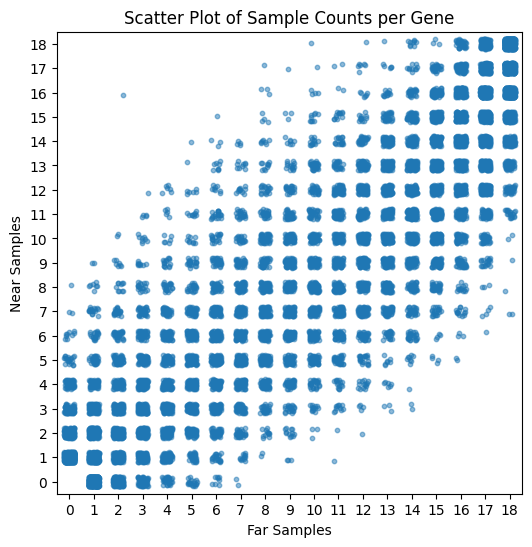

Few-sample mask generated:
id
ENSRNOG00000000001    False
ENSRNOG00000000007     True
ENSRNOG00000000010     True
ENSRNOG00000000012    False
ENSRNOG00000000021     True
dtype: bool
Filter 2 applied. Total genes remaining after sample count filtering: 12650
Empty extName entries *after* Filter 2: 1115


In [13]:
#Minimum threshold of three samples for each gene
min_samp = 3


#raw counts > 0
s1 = (updated_data_new['rc1'] > 0).sum(axis=1)
s2 = (updated_data_new['rc2'] > 0).sum(axis=1)


more_samples = (s1 >= min_samp) & (s2 >= min_samp)
print("Boolean mask for genes with sufficient sample presence generated.")
print(more_samples[:5])


s1_jittered = s1 + np.random.uniform(-0.2, 0.2, size=s1.shape)
s2_jittered = s2 + np.random.uniform(-0.2, 0.2, size=s2.shape)

plt.figure(figsize=(6, 6))
plt.scatter(s1_jittered, s2_jittered, s=10, alpha=0.5)
plt.xlabel('Far Samples')
plt.ylabel('Near Samples')
plt.title('Scatter Plot of Sample Counts per Gene')
plt.xlim(-0.5, 18.5)
plt.ylim(-0.5, 18.5)
plt.xticks(range(0, 19))
plt.yticks(range(0, 19))

# Save all the plot to 'resultsandplots' folder. Creating the folder if it doesn't exist.
os.makedirs('resultsandplots', exist_ok=True)
plt.savefig('resultsandplots/sample_count_scatter_plot.png', dpi=600)
plt.show()

def generate_non_zero_mask(data, ids, min_samp):
    rc1_df = pd.DataFrame(data['rc1'])
    rc2_df = pd.DataFrame(data['rc2'])

    s1 = (rc1_df > 0).sum(axis=1)
    s2 = (rc2_df > 0).sum(axis=1)

    more_samples = (s1 >= min_samp) & (s2 >= min_samp)

    mask_series = pd.Series(more_samples.values, index=ids)
    mask_series.index.name = 'id'
    return mask_series

fewsample_mask = generate_non_zero_mask(filtered_data_1count, filtered_data_1count['name'], min_samp)
print("Few-sample mask generated:")
print(fewsample_mask[:5])

#data Filtration using few_sampel mask.
def filter_data_by_moresample(data, high_raw_counts):
    filtered_name = []
    filtered_extName = []
    filtered_rc1 = []
    filtered_rc2 = []
    filtered_nc1 = []
    filtered_nc2 = []

    for i, gene_id in enumerate(data['name']):  
        if high_raw_counts.loc[gene_id]: 
            filtered_name.append(gene_id)
            filtered_extName.append(data['extName'][i])
            filtered_rc1.append(data['rc1'][i])  
            filtered_rc2.append(data['rc2'][i])
            filtered_nc1.append(data['nc1'][i])
            filtered_nc2.append(data['nc2'][i])

    filtered_data = {
        'name': filtered_name,
        'extName': filtered_extName,
        'rc1': filtered_rc1,
        'rc2': filtered_rc2,
        'nc1': filtered_nc1,
        'nc2': filtered_nc2
    }
    return filtered_data

filtered_data_2moresample = filter_data_by_moresample(filtered_data_1count, fewsample_mask)
print(f"Filter 2 applied. Total genes remaining after sample count filtering: {len(filtered_data_2moresample['name'])}")
remaining_empty_names = sum(1 for ext in filtered_data_2moresample['extName'] if ext.strip() == '')
print(f"Empty extName entries *after* Filter 2: {remaining_empty_names}")

Filtering the dataset when the genes doen't have any external names. (Filter 3)

In [14]:
empty_extName_count = sum(1 for extName in filtered_data_2moresample['extName'] if extName.strip() == '')
def filter_extName_empty_or_space(data):
    filtered_name = []
    filtered_extName = []
    filtered_rc1 = []
    filtered_rc2 = []
    filtered_nc1 = []
    filtered_nc2 = []
    for i, ext_name in enumerate(data['extName']):
        if ext_name.strip():
            filtered_name.append(data['name'][i])
            filtered_extName.append(ext_name)
            filtered_rc1.append(data['rc1'][i])
            filtered_rc2.append(data['rc2'][i])
            filtered_nc1.append(data['nc1'][i])
            filtered_nc2.append(data['nc2'][i])
    filtered_data = {
        'name': filtered_name,
        'extName': filtered_extName,
        'rc1': filtered_rc1,
        'rc2': filtered_rc2,
        'nc1': filtered_nc1,
        'nc2': filtered_nc2
    }

    return filtered_data

filtered_data_3noname = filter_extName_empty_or_space(filtered_data_2moresample)
print(f"Filter 3 applied. Total genes remaining after empty name filtering: {len(filtered_data_3noname['name'])}")

Filter 3 applied. Total genes remaining after empty name filtering: 11535


This filter removes genes based on Ensembl annotations, using three criteria:
1. Not protein-coding
2. Too short (length < min_len)
3. No Ensembl data available (hasEnsData == False)

In [15]:
def filter_and_compare_gene_df(data, gene_df, min_len):
    gene_df['length'] = pd.to_numeric(gene_df['length'], errors='coerce')
    gene_df_subset = gene_df[gene_df['name'].isin(data['extName'])]

    not_coding_gene = gene_df_subset['type'] != 'protein_coding'
    too_short = gene_df_subset['length'] < min_len
    no_data = ~gene_df_subset['hasEnsData']

    mask = no_data | not_coding_gene | too_short
    filtered_gene_names = gene_df_subset.loc[mask, 'name']

    filtered_indices = [i for i, ext_name in enumerate(data['extName']) 
                        if ext_name not in filtered_gene_names.values]

    filtered_data = {
        'name': [data['name'][i] for i in filtered_indices],
        'extName': [data['extName'][i] for i in filtered_indices],
        'rc1': [data['rc1'][i] for i in filtered_indices],
        'rc2': [data['rc2'][i] for i in filtered_indices],
        'nc1': [data['nc1'][i] for i in filtered_indices],
        'nc2': [data['nc2'][i] for i in filtered_indices]
    }

    
    excluded_gene_names = set(data['extName']).intersection(set(filtered_gene_names))
    print(f"Genes filtered in this step (non-coding, short, or missing data): {len(excluded_gene_names)}")

    return filtered_data, filtered_gene_names

#minimum gene length
min_len = 100

filtered_data_4_otherfilters, filtered_gene_names_final = filter_and_compare_gene_df(
    filtered_data_3noname, gene_df, min_len
)

print(f"Final gene count after all filters: {len(filtered_data_4_otherfilters['name'])}")


Genes filtered in this step (non-coding, short, or missing data): 126
Final gene count after all filters: 11400


In [16]:
#Summary Table: 
initial_count = len(updated_data_new['name'])
filter1_count = len(filtered_data_1count['name'])
filter2_count = len(filtered_data_2moresample['name'])
filter3_count = len(filtered_data_3noname['name'])
filter4_count = len(filtered_data_4_otherfilters['name'])

tracking_log = {
    "Filter": [
        "Initial Input",
        "Filter 1: Raw/Normalized Count Threshold",
        "Filter 2: Min Sample Count per Condition",
        "Filter 3: Valid extName",
        "Filter 4: Ensembl Annotation Filter"
    ],
    "Gene Count": [
        initial_count,
        filter1_count,
        filter2_count,
        filter3_count,
        filter4_count
    ]
}

tracking_df = pd.DataFrame(tracking_log)

print("Gene Filtering Progress:")
display(tracking_df)


Gene Filtering Progress:


,Filter,Gene Count
0,Initial Input,17317
1,Filter 1: Raw/Normalized Count Threshold,15191
2,Filter 2: Min Sample Count per Condition,12650
3,Filter 3: Valid extName,11535
4,Filter 4: Ensembl Annotation Filter,11400


Spearman Correlation & FDR Threshold
---

This function calculates pairwise Spearman correlation coefficients and p-values for the two conditions 'near' and 'far' denoted by nc1 and nc2 (normalized counts). It focuses on the bottom triangles of the correlation and p-value matrices to remove redundancy from the symmetric matrix. To discover statistically significant gene-gene correlations, the function sums the results from both conditions and uses a False Discovery Rate (FDR) correction at multiple significance thresholds (0.1, 0.5, and 0.9). For each FDR level, it computes essential metrics such as the number of discoveries (k*), the p-value cutoff (p*), the corresponding minimal correlation magnitude (c*), and the proportion of significant pairs. The output contains the full correlation and p-value matrices for both circumstances, as well as a summary of FDR-based.

In [17]:
def compute_correlations(data):

    
    C1_corr, C1_pvals = spearmanr(data['nc1'], axis=1)
    C2_corr, C2_pvals = spearmanr(data['nc2'], axis=1)

    lower_indices = np.tril_indices(C1_corr.shape[0], k=-1)

    C1_pvals_lower = C1_pvals[lower_indices]
    C1_corr_lower = C1_corr[lower_indices]
    C2_pvals_lower = C2_pvals[lower_indices]
    C2_corr_lower = C2_corr[lower_indices]

    combined_pvals = np.concatenate((C1_pvals_lower, C2_pvals_lower))
    combined_cvals = np.concatenate((C1_corr_lower, C2_corr_lower))


    sorted_indices = np.argsort(combined_pvals)
    combined_pvals_sorted = combined_pvals[sorted_indices]
    combined_cvals_sorted = combined_cvals[sorted_indices]

    M = len(combined_pvals_sorted)
    FPR_levels = [0.1, 0.5, 0.9]
    fdr_results = {}


    for FPR in FPR_levels:
        kstar_indices = np.where(combined_pvals_sorted < (np.arange(1, M + 1) * FPR / M))[0]


        if len(kstar_indices) > 0:
            kstar = max(kstar_indices)
            prc = kstar / M
            pstar = combined_pvals_sorted[kstar]
            cstar = abs(combined_cvals_sorted[kstar])

            fdr_results[FPR] = {
                "kstar": kstar,
                "prc": prc,
                "pstar": pstar,
                "cstar": cstar
            }
        else:
            fdr_results[FPR] = {
                "kstar": None,
                "prc": None,
                "pstar": None,
                "cstar": None
            }

    return {
        "C1_corr": C1_corr,
        "C1_pvals": C1_pvals,
        "C2_corr": C2_corr,
        "C2_pvals": C2_pvals,
        "FDR_thresholds": fdr_results
    }

results = compute_correlations(filtered_data_4_otherfilters)

#Summary
print("FDR 10% P-value:", results['FDR_thresholds'][0.1]['pstar'])
print("FDR 10% Correlation:", results['FDR_thresholds'][0.1]['cstar'])
print("FDR 50% P-value:", results['FDR_thresholds'][0.5]['pstar'])
print("FDR 50% Correlation:", results['FDR_thresholds'][0.5]['cstar'])
print("FDR 90% P-value:", results['FDR_thresholds'][0.9]['pstar'])
print("FDR 90% Correlation:", results['FDR_thresholds'][0.9]['cstar'])

FDR 10% P-value: 4.974862279747091e-05
FDR 10% Correlation: 0.8080495356037152
FDR 50% P-value: 0.0041595509943915246
FDR 50% Correlation: 0.6408668730650156
FDR 90% P-value: 0.1445292896615503
FDR 90% Correlation: 0.35810113519091846


In [18]:
#Function to find strongly connected genes based on correlation thresholds
def find_strongly_connected_genes(corrs, cstar10, cstar50, min_corr_threshold=200):
    os.makedirs("resultsandplots", exist_ok=True)
    sum1 = np.sum(corrs['C1'] > cstar10, axis=1) + np.sum(corrs['C2'] > cstar10, axis=1)
    sum2 = np.sum(corrs['C1'] > cstar50, axis=1) + np.sum(corrs['C2'] > cstar50, axis=1)

    #Histogram above 10% FDR
    plt.figure()
    plt.hist(sum1, bins=100)
    plt.title("Number of correlations above 10% FDR")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.savefig("resultsandplots/hist_corrs_above_10FDR.png", dpi=300)
    plt.close()

    #Histogram above 50% FDR
    plt.figure()
    plt.hist(sum2, bins=100)
    plt.title("Number of correlations above 50% FDR")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
    plt.savefig("resultsandplots/hist_corrs_above_50FDR.png", dpi=300)
    plt.close()

    # Scatter plot comparing 10% and 50% FDR connectivity per gene. Each point is a gene. 
    plt.figure()
    plt.scatter(sum2, sum1, s=1)
    plt.xlabel("Number of correlations above 50% FDR")
    plt.ylabel("Number of correlations above 10% FDR")
    plt.title("Strongly Connected Genes (Each Point = One Gene)")
    plt.savefig("resultsandplots/scatter_corrs_10vs50FDR.png", dpi=300)
    plt.close()

    # Boolean mask for genes with strong connectivity
    testSC = sum2 > min_corr_threshold
    return testSC


# Function to extract a subset of correlation matrices based on the generated mask for strongly connected genes
def find_strongly_connected_genes_subset(corrs, test):
    corrsSC = {
        'C1': corrs['C1'][np.ix_(test, test)],
        'C2': corrs['C2'][np.ix_(test, test)]
    }
    return corrsSC

corrs = {
    'C1': results['C1_corr'],
    'C2': results['C2_corr']
}

#Correlation thresholds at FDR 10% and 50%
cstar10 = results['FDR_thresholds'][0.1]['cstar']
cstar50 = results['FDR_thresholds'][0.5]['cstar']

#Strongly connected genes
testSC = find_strongly_connected_genes(corrs, cstar10, cstar50, min_corr_threshold=200) #This threshold can be changed 

# Subset correlation matrices to only SCG
corrsSC = find_strongly_connected_genes_subset(corrs, testSC)


num_strongly_connected = np.sum(testSC)
total_genes = corrs['C1'].shape[0]
percentage_strongly_connected = (num_strongly_connected / total_genes) * 100

print(f"Number of strongly connected genes: {num_strongly_connected} ({percentage_strongly_connected:.2f}% of total filtered genes {total_genes})")


Number of strongly connected genes: 1722 (15.11% of total filtered genes 11400)


TOM Distance
---



D is our NxN adjacency (or adjacency-difference) matrix, with zeros on diagonal.
Returns NxN matrix of TOM distances = 1 - TOM.

The topological overlap TOM_{i,j} is computed as:

numerator   = (D[i,k] * D[j,k]) + D[i,j]

denominator = min(sum_k D[i,k], sum_k D[j,k] ) + 1.0 - D[i,j]

TOM[i,j] = numerator / denominator

Then we define the distance as TOMdist[i,j] = 1.0 - TOM[i,j].

This approach is from the WGCNA / DiffCoEx.


In [19]:
def compute_TOM_distance(D):
    
    N = D.shape[0]
    np.fill_diagonal(D,0) #The Diagonal is set to zero to get rid of the self-adjacency
    rowSum = np.sum(D,axis=1) #This is the Row Sum

    TOM = np.zeros((N, N), dtype=np.float64) #TOM Array Initialization

    #Here, we are computing only the upper triangle, then mirror
    for i in range(N):
        for j in range(i+1, N):
            shared = 0.0
            for k in range(N):
                shared += D[i,k]*D[k,j]
                
            numerator = shared + D[i,j]    #Neumerator      
            denominator = min(rowSum[i],rowSum[j]) + 1.0 - D[i,j] #Denominator

            if denominator!= 0:
                TOM[i,j] = numerator/denominator
            else:
                TOM[i,j] = 0.0

            # Mirror
            TOM[j,i] = TOM[i,j]

    TOMdist = 1.0 - TOM   #COnvert to Distance Matrix
    return TOMdist

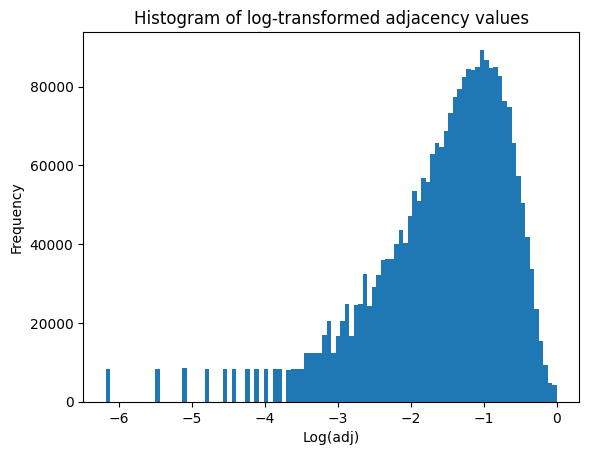

In [20]:
def compute_adjacency(corrs, cap=1, threshold=0.03):

    os.makedirs("resultsandplots", exist_ok=True)

    #x1 = np.copy(corrs['C1'])
    #x2 = np.copy(corrs['C2'])
    #x1[x1 < 0.001] = 0
    #x2[x2 < 0.001] = 0

    #A = np.abs(x1 - x2)
    #A[A > cap] = cap #Using cap = 1
    #A /= cap #Scaling to [0,1]
    
    C1 = corrs['C1'].copy()
    C2 = corrs['C2'].copy()
    C1[C1< threshold] = 0
    C2[C2< threshold] = 0
    A_diff = np.abs(C1 - C2)
    #A_diff[A_diff < threshold] = 0
    
    
    
    A = np.clip(A_diff,0,cap)/cap    #Clipping at cap=1 and Scaling 
    np.fill_diagonal(A, 1.0)    #Diagonal is set to 1. 

    #histogram of log(A)
    plt.figure()
    plt.hist(np.log(A[A > 0]).flatten(), bins=100)
    plt.title("Histogram of log-transformed adjacency values")
    plt.xlabel("Log(adj)")
    plt.ylabel("Frequency")

    save_path = os.path.join("resultsandplots", "hist_log_adjacency.png")
    plt.savefig(save_path, dpi=600)
    plt.show()

    #This is the function to calculate the TOM Distance. The Function is called here. 
    TOMdist = compute_TOM_distance(A)

    return {
        'cap': cap,
        'Adj': A,        #Adj Matrix
        'TOMdist': TOMdist  #NxN matrix of topological-overlap distances
    }

adSC = compute_adjacency(corrsSC, cap=1, threshold=0.03)  #Here, adSC['Adj'] will be the Adj Difference Matrix and adsc['TOMdist'] is the TOM. We will use this TOM for UMAP


UMAP & DBSCAN based Plotting
--

Umap Embedding

/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


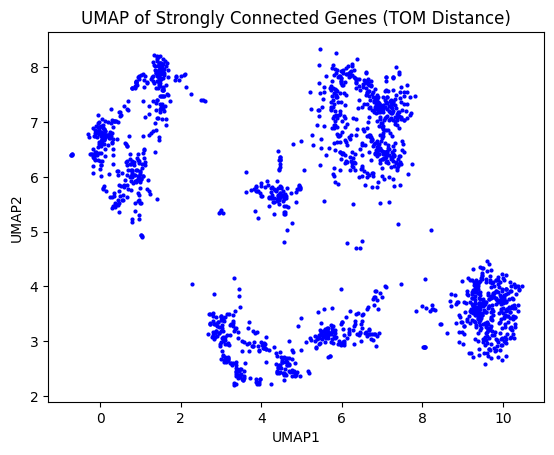

In [76]:
def quick_umap(distance_matrix, n_neighbors=15, min_dist=0.1, seed=123, n_components=2):
    
    #UMAP interprets 'distance_matrix' as an NxN distance matrix:
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=seed,   #Random Seed is used for reproducibility
        metric='precomputed'  #We have to use 'precomputed' here to use the TOM distance calculated before
    )
    embedding = reducer.fit_transform(distance_matrix)

    if n_components == 2:
        return pd.DataFrame({'x': embedding[:, 0], 'y': embedding[:, 1]})
    else:
        return pd.DataFrame({'x': embedding[:, 0],
                             'y': embedding[:, 1],
                             'z': embedding[:, 2]})


umapSC = quick_umap(adSC['TOMdist'], n_neighbors=3, min_dist=0.001, seed=123, n_components=2)

plt.figure()
plt.scatter(umapSC['x'], umapSC['y'], s=4, c='blue')
plt.title("UMAP of Strongly Connected Genes (TOM Distance)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.savefig("resultsandplots/umap_tom_embedding.png", dpi=600)
plt.show()

DBSCAN Plot

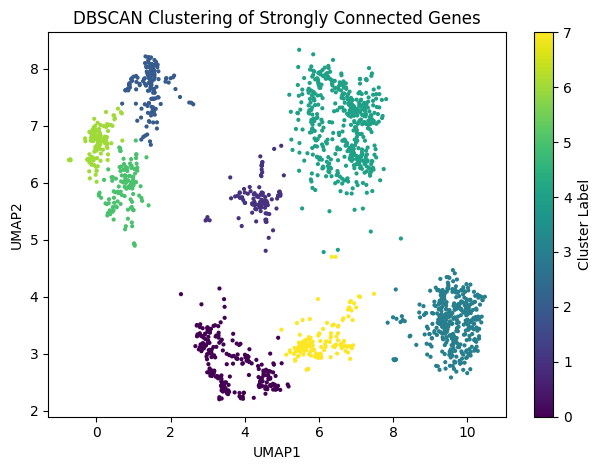

In [96]:
import numpy as np
from sklearn.cluster import DBSCAN

def density_cluster(umap_embedding, eps, min_samples, min_mod_size, merge0=True):
    
    if hasattr(umap_embedding, 'values'):
        coords = umap_embedding[['x', 'y']].values
    else:
        coords = umap_embedding

    #DBSCAN in Euclidean space. As I have used scikit-learn - it labels noise as -1
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    dbscan.fit(coords)
    mods = dbscan.labels_  #example: 0,1,2,... or -1 for noise

    unique_labels = set(mods) - {-1}    #(-1) is noise here. 
    for m in unique_labels:
        cluster_size = np.sum(mods == m)
        if cluster_size <= min_mod_size:
            mods[mods == m] = -1  #Mark these points as noise

    #If merge0=True, assign noise points to the nearest cluster
    if merge0:
        noise_indices = np.where(mods == -1)[0]
        if len(noise_indices) > 0:
            cluster_indices = np.where(mods != -1)[0]
            if len(cluster_indices) == 0:
                pass
            else:
                for idx in noise_indices:
                    distances = np.linalg.norm(coords[cluster_indices] - coords[idx], axis=1)
                    nearest_idx = cluster_indices[np.argmin(distances)]
                    mods[idx] = mods[nearest_idx]

    valid_labels = sorted(label for label in np.unique(mods) if label != -1)

    label_map = {}
    for i, old_label in enumerate(valid_labels):
        label_map[old_label] = i


    new_mods = []
    for label in mods:
        if label == -1:
            new_mods.append(-1)   
        else:
            new_mods.append(label_map[label])
    mods = np.array(new_mods, dtype=int)

    return mods


modsSC = density_cluster( umapSC, eps=0.3, min_samples=13, min_mod_size=50, merge0=True)

sc = plt.scatter(umapSC['x'], umapSC['y'], c=modsSC, cmap='viridis', s=4)
plt.title('DBSCAN Clustering of Strongly Connected Genes')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')



cbar = plt.colorbar(sc, ticks=np.unique(modsSC))
cbar.set_label('Cluster Label')
cbar.ax.set_yticklabels([str(int(c)) if c != -1 else 'Noise' for c in np.unique(modsSC)])

plt.tight_layout()
plt.savefig("resultsandplots/umap+dbscan plot.png", dpi=600)
plt.show()

Cluster Evaluation using Silhoitte and DBI Scores
---

In [69]:
def evaluate_clusters(data, labels):
    if len(set(labels)) > 1:
        s_score = silhouette_score(data, labels)
        db_index = davies_bouldin_score(data, labels)
    else:
        s_score = -1
        db_index = float('inf')
    return s_score, db_index


cluster_metrics = evaluate_clusters(umapSC, modsSC)
print(cluster_metrics)


(0.63397866, 0.4869190961953809)


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank


Top Grid Search Results (by composite score):
    n_neighbors  min_dist  eps  min_samples  min_mod_size  silhouette_score  \
0             3     0.001  0.3           10            50          0.655706   
9             3     0.010  0.4           10            50          0.664797   
11            3     0.010  0.4           13            50          0.663529   
10            3     0.010  0.4           12            50          0.663529   
4             3     0.001  0.4           12            50          0.633979   

    davies_bouldin_index  silhouette_norm  dbi_norm  composite_score  
0               0.440490         0.956986  1.000000         0.980644  
9               0.490490         1.000000  0.805077         0.892793  
11              0.493018         0.993997  0.795222         0.884671  
10              0.493018         0.993997  0.795222         0.884671  
4               0.486919         0.854190  0.818998         0.834834  

Saved full grid search results to: resultsandplots/

/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


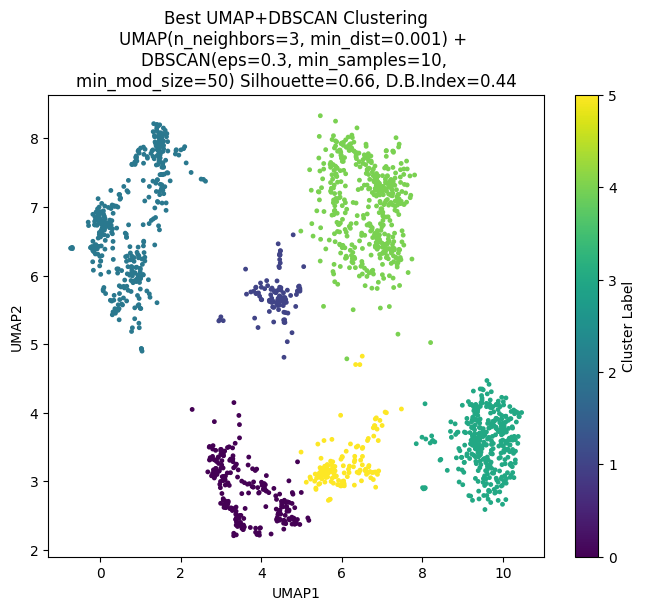

Saved final best cluster plot as: resultsandplots/best_umap_dbscan.png


In [104]:
def evaluate_clusters(data, labels):
    if len(set(labels)) > 1:
        return silhouette_score(data, labels), davies_bouldin_score(data, labels)
    else:
        return -1, np.inf


def grid_search_umap_dbscan(
    distance_matrix,
    n_neighbors_range,
    min_dist_range,
    eps_range,
    min_samples_range,
    min_mod_size_range,
    merge0,
    seed=123
):
    results = []

    for n_neighbors, min_dist, eps, min_samples, min_mod_size in product(
        n_neighbors_range, min_dist_range, eps_range, min_samples_range, min_mod_size_range
    ):
        try:
            umap_emb = quick_umap(
                distance_matrix=distance_matrix,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                seed=seed,
                n_components=2
            )
            labels = density_cluster(
                umap_embedding=umap_emb,
                eps=eps,
                min_samples=min_samples,
                min_mod_size=min_mod_size,
                merge0=merge0
            )

            s_score, db_index = evaluate_clusters(umap_emb[['x', 'y']].values, labels)

            results.append({
                'n_neighbors': n_neighbors,
                'min_dist': min_dist,
                'eps': eps,
                'min_samples': min_samples,
                'min_mod_size': min_mod_size,
                'silhouette_score': s_score,
                'davies_bouldin_index': db_index
            })

        except Exception as e:
            print(f"Error with combo: n_neighbors={n_neighbors}, min_dist={min_dist}, "
                  f"eps={eps}, min_samples={min_samples}, min_mod_size={min_mod_size}. Error: {e}")

    df = pd.DataFrame(results)

    # Droping rows with NaNs or inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Normalize scores
    df['silhouette_norm'] = (df['silhouette_score'] - df['silhouette_score'].min()) / (
        df['silhouette_score'].max() - df['silhouette_score'].min()
    )
    df['dbi_norm'] = 1 - (df['davies_bouldin_index'] - df['davies_bouldin_index'].min()) / (
        df['davies_bouldin_index'].max() - df['davies_bouldin_index'].min()
    )

    # Composite score
    df['composite_score'] = 0.45* df['silhouette_norm'] + 0.55* df['dbi_norm']

    return df


if __name__ == "__main__":

    distance_matrix = adSC["TOMdist"]

    n_neighbors_range  = [3, 5]
    min_dist_range     = [0.001, 0.01]
    eps_range          = [0.3, 0.4]
    min_samples_range  = [10,12,13]
    min_mod_size_range = [50]

    MERGE_NOISE = True

    results_df = grid_search_umap_dbscan(
        distance_matrix=distance_matrix,
        n_neighbors_range=n_neighbors_range,
        min_dist_range=min_dist_range,
        eps_range=eps_range,
        min_samples_range=min_samples_range,
        min_mod_size_range=min_mod_size_range,
        merge0=MERGE_NOISE,
        seed=123
    )

    # Sort by composite score
    results_df = results_df.sort_values(by='composite_score', ascending=False)

    print("\nTop Grid Search Results (by composite score):")
    print(results_df.head(5))

    csv_path = os.path.join("resultsandplots", "umap_dbscan_gridsearch.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"\nSaved full grid search results to: {csv_path}")

    top_n = 9
    top_params_df = results_df.head(top_n)
    top_param_path = os.path.join("resultsandplots", "top_9_clustering_parameters.csv")
    top_params_df.to_csv(top_param_path, index=False)
    print(f"Saved top {top_n} clustering parameters to: {top_param_path}")

    best_params = results_df.iloc[0]
    best_umap = quick_umap(
        distance_matrix=distance_matrix,
        n_neighbors=int(best_params['n_neighbors']),
        min_dist=float(best_params['min_dist']),
        seed=123,
        n_components=2
    )

    best_labels = density_cluster(
        umap_embedding=best_umap,
        eps=float(best_params['eps']),
        min_samples=int(best_params['min_samples']),
        min_mod_size=int(best_params['min_mod_size']),
        merge0=MERGE_NOISE
    )

    # Plot best clustering
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(best_umap['x'], best_umap['y'], c=best_labels, cmap='viridis', s=6)

    
    sil_val = float(best_params['silhouette_score'])
    db_val = float(best_params['davies_bouldin_index'])

    
    title_str = (
        f"Best UMAP+DBSCAN Clustering\n"
        f"UMAP(n_neighbors={int(best_params['n_neighbors'])}, min_dist={float(best_params['min_dist']):.3f}) + \n"
        f"DBSCAN(eps={float(best_params['eps'])}, min_samples={int(best_params['min_samples'])}, \n"
        f"min_mod_size={int(best_params['min_mod_size'])})"
        f" Silhouette={sil_val:.2f}, D.B.Index={db_val:.2f}"
    )

    plt.title(title_str)2025
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    cbar = plt.colorbar(sc, ticks=np.unique(best_labels))
    cbar.set_label("Cluster Label")
    cbar.ax.set_yticklabels([str(lbl) if lbl != -1 else "Noise" for lbl in np.unique(best_labels)])

    final_plot_path = os.path.join("resultsandplots", "best_umap_dbscan.png")
    plt.savefig(final_plot_path, dpi=600)
    plt.show()
    print(f"Saved final best cluster plot as: {final_plot_path}")


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/anirban/miniconda3/envs/diffcorank

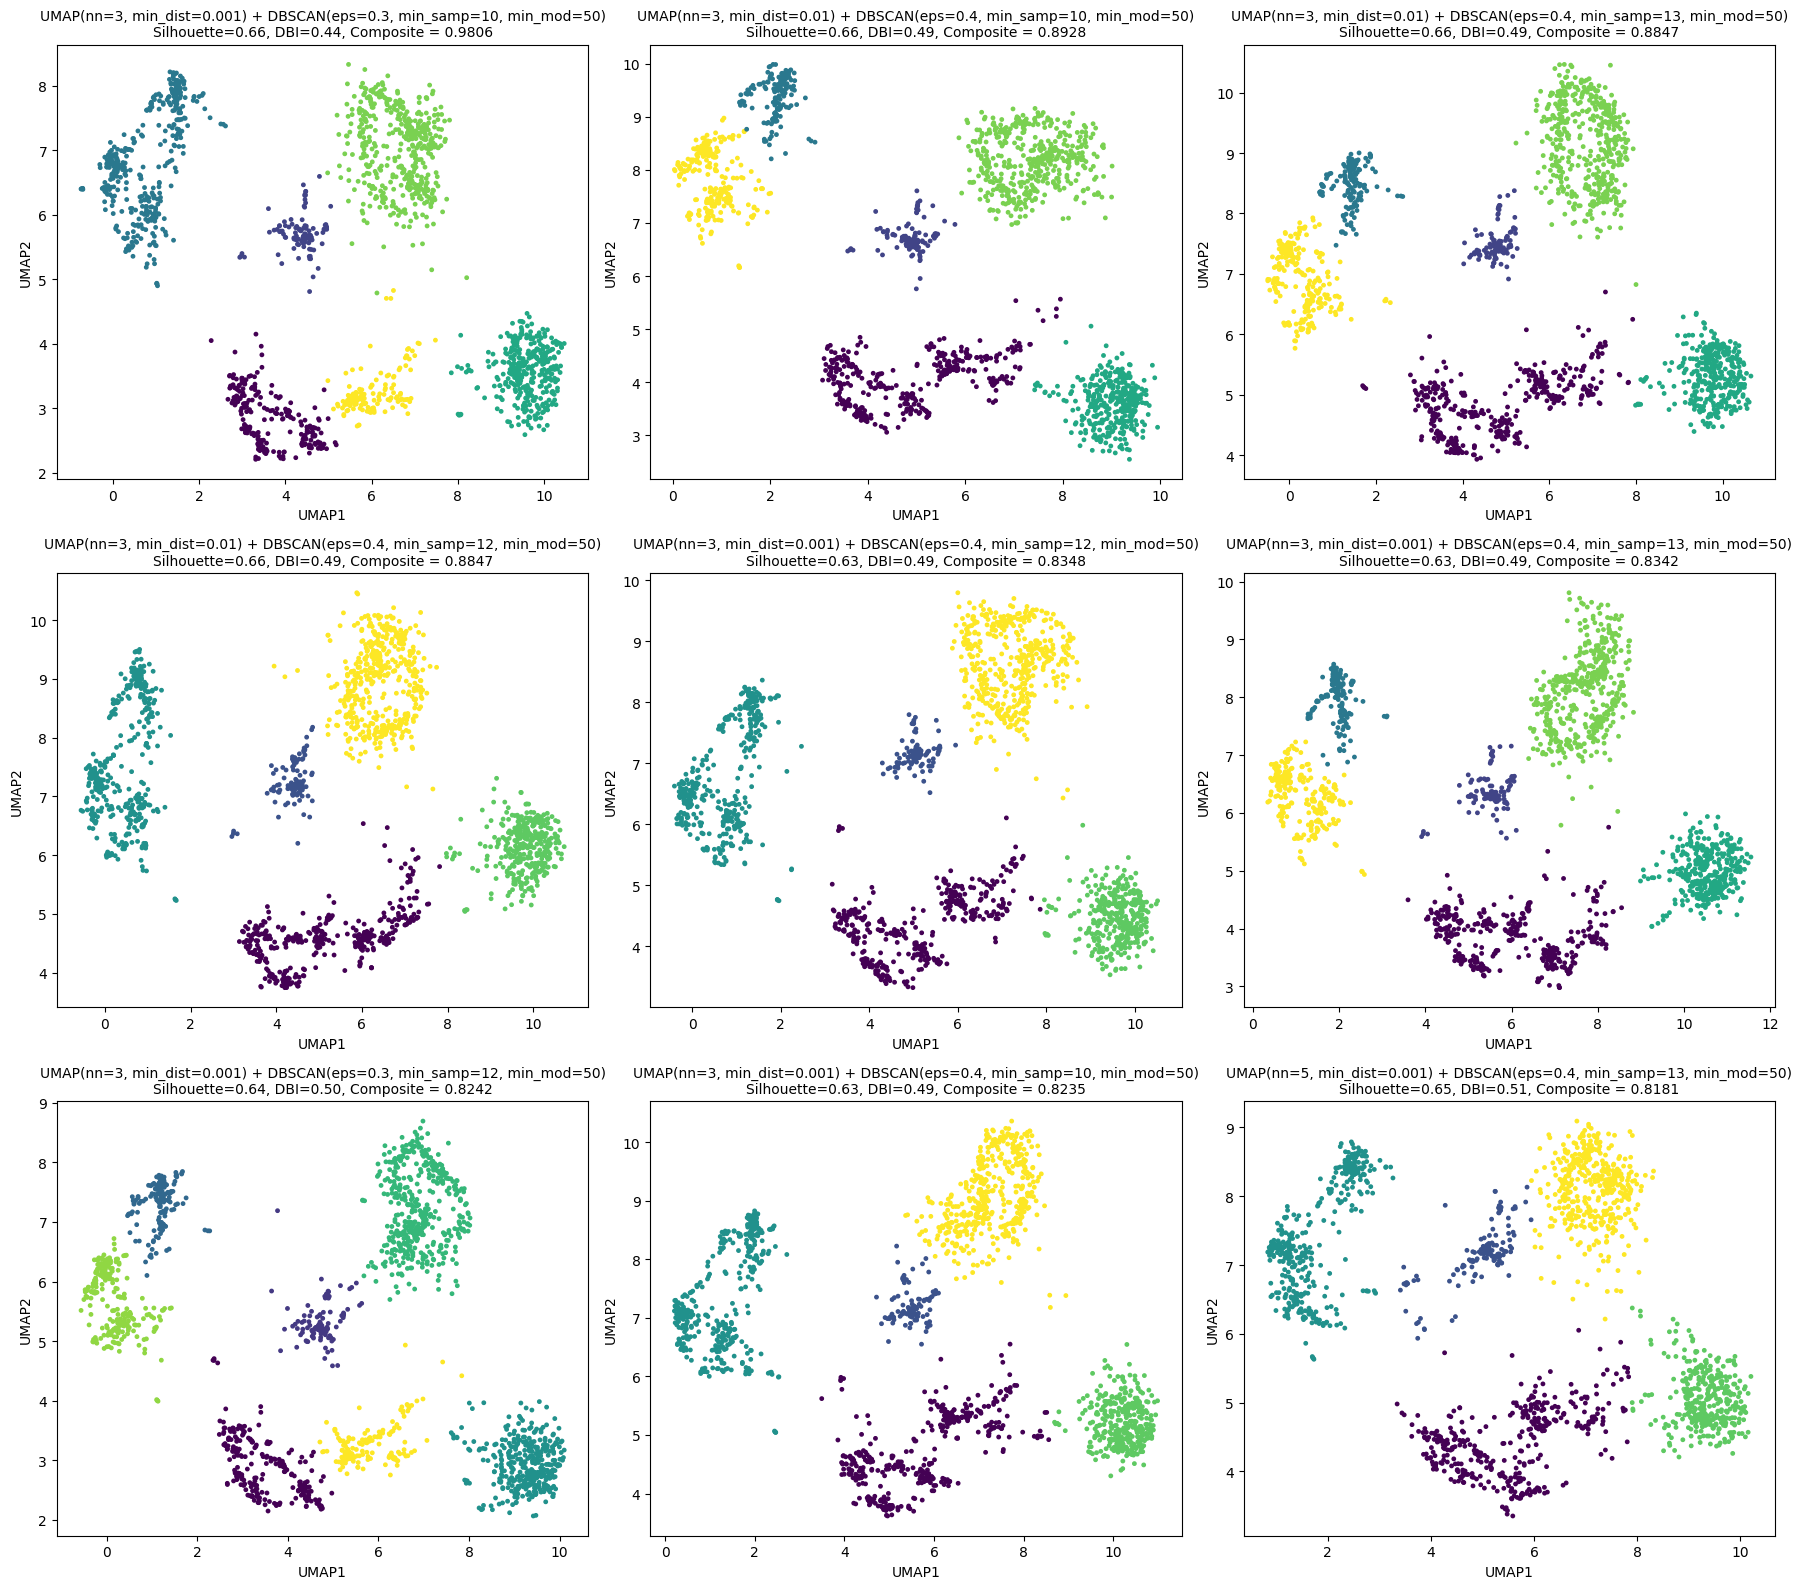

Saved top 9 UMAP+DBSCAN clustering subplots to: resultsandplots/top9_umap_dbscan_subplots.png


In [105]:
top_param_path = os.path.join("resultsandplots", "top_9_clustering_parameters.csv")
top_results = pd.read_csv(top_param_path)

top_results = top_results.head(9)
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

distance_matrix = adSC['TOMdist']

for i, (_, row) in enumerate(top_results.iterrows()):       
    ax = axes[i]

    nn = int(row['n_neighbors'])
    md = float(row['min_dist'])
    eps = float(row['eps'])
    ms = int(row['min_samples'])
    mmsize = int(row['min_mod_size'])

    sil_val = float(row['silhouette_score'])
    db_val = float(row['davies_bouldin_index'])
    cm_val = float(row['composite_score'])

    umap_emb = quick_umap(
        distance_matrix=distance_matrix,
        n_neighbors=nn,
        min_dist=md,
        seed=123+i,
        n_components=2
    )

    labels = density_cluster(
        umap_embedding=umap_emb,
        eps=eps,
        min_samples=ms,
        min_mod_size=mmsize,
        merge0=True
    )

    sc = ax.scatter(umap_emb['x'], umap_emb['y'], c=labels, cmap='viridis', s=6)
    title = (f"UMAP(nn={nn}, min_dist={md}) + "
             f"DBSCAN(eps={eps}, min_samp={ms}, min_mod={mmsize})\n"
             f"Silhouette={sil_val:.2f}, DBI={db_val:.2f}, Composite = {cm_val:.4f}")
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

for j in range(len(top_results), 9):
    axes[j].axis('off')

plt.tight_layout()
plot_path = os.path.join("resultsandplots", "top9_umap_dbscan_subplots.png")
plt.savefig(plot_path, dpi=600)
plt.show()

print(f"Saved top 9 UMAP+DBSCAN clustering subplots to: {plot_path}")

Network Analysis and Hub gene Identification
---

In [135]:
import glob

def analyze_module(mods, module_num, data_main, adSC, corrsSC, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    module_indices = np.where(mods == module_num)[0]
    A = adSC['Adj'][np.ix_(module_indices, module_indices)]
    G = nx.from_numpy_array(A)   #This is adjacency
    G_Distance  = nx.from_numpy_array(1 - A)   #Subtracting the graph weight from 1 to get the true distance (not TOM distance for Network Calculation) from adjacency

    deg = dict(G.degree(weight='weight'))        # Original weights for degree. 
    clo = nx.closeness_centrality(G_Distance, distance='weight')  #It is needed for Closeness - See Documentation
    bet = nx.betweenness_centrality(G_Distance, weight='weight')  #(distance) - It is needed for Betweenness - See Documentation. Weight is interpreted as distance
    eig = nx.eigenvector_centrality_numpy(G, weight='weight')  # Original weights. Weight is the connection Strength here - Adjacency

    df = pd.DataFrame({
        'gene_names': [data_main['name'][i] for i in module_indices],
        'ext_names': [data_main['extName'][i] for i in module_indices],
        'degree': pd.Series(deg),
        'closeness': pd.Series(clo),
        'betweenness': pd.Series(bet),
        'eigenvector': pd.Series(eig)
    })

    for col in ['degree', 'closeness', 'betweenness', 'eigenvector']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['degRank']   = df['degree'].rank(ascending=False, method='dense')
    df['closeRank'] = df['closeness'].rank(ascending=False, method='dense')
    df['eigRank']   = df['eigenvector'].rank(ascending=False, method='dense')
    df['betRank']   = df['betweenness'].rank(ascending=False, method='dense')
    df['avgRank']   = df[['degRank', 'closeRank', 'eigRank']].mean(axis=1)

    df.to_csv(f"{out_dir}/module_{module_num}.csv", index=False, float_format='%.4f')
    return df


def write_compare_modules(csv_directory, output_file):
    files = glob.glob(f'{csv_directory}/module_*.csv')
    summary = {
        'identifier': [], 'size': [], 'medianDegree': [],
        'maxDegree': [], 'correlatedCondition': [], 'hubGene': []
    }

    for f in files:
        df = pd.read_csv(f)
        mod_num = int(f.split('_')[-1].split('.')[0])
        df['avgRank'] = df[['degRank', 'closeRank', 'eigRank']].mean(axis=1)
        hub = df.loc[df['avgRank'].idxmin(), 'ext_names']
        summary['identifier'].append(mod_num)
        summary['size'].append(len(df))
        summary['medianDegree'].append(df['degree'].median())
        summary['maxDegree'].append(df['degree'].max())
        summary['correlatedCondition'].append('N/A')
        summary['hubGene'].append(hub)

    pd.DataFrame(summary).to_csv(output_file, index=False)
    print(f"Saved: {output_file}")


In [136]:
top_params_path = "resultsandplots/top_9_clustering_parameters.csv"
top_configs = pd.read_csv(top_params_path)


distance_matrix = adSC["TOMdist"]

#Looping through each top parameter set
for i, row in top_configs.iterrows():

    print(f"\nRunning clustering and module analysis for Top-{i} config...")

    nn     = int(row['n_neighbors'])
    md     = float(row['min_dist'])
    eps    = float(row['eps'])
    ms     = int(row['min_samples'])
    mmsize = int(row['min_mod_size'])


    umap_emb = quick_umap(
        distance_matrix=distance_matrix,
        n_neighbors=nn,
        min_dist=md,
        seed=123 + i,  
        n_components=2
    )

    modsSC = density_cluster(
        umap_embedding=umap_emb,
        eps=eps,
        min_samples=ms,
        min_mod_size=mmsize,
        merge0=True
    )

    config_dir = f"resultsandplots/modules/top_{i}"
    os.makedirs(config_dir, exist_ok=True)


    mod_list = []
    for m in np.unique(modsSC):
        if m != -1:
            mod_list.append(
                analyze_module(
                    mods=modsSC,
                    module_num=m,
                    data_main=filtered_data_4_otherfilters,
                    adSC=adSC,
                    corrsSC=corrsSC,
                    out_dir=config_dir
                )
            )


    compare_path = f"resultsandplots/compareModules_top_{i}.csv"
    write_compare_modules(csv_directory=config_dir, output_file=compare_path)

    print(f"Finished Top-{i}. Summary written to: {compare_path}")



Running clustering and module analysis for Top-0 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_0.csv
Finished Top-0. Summary written to: resultsandplots/compareModules_top_0.csv

Running clustering and module analysis for Top-1 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_1.csv
Finished Top-1. Summary written to: resultsandplots/compareModules_top_1.csv

Running clustering and module analysis for Top-2 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_2.csv
Finished Top-2. Summary written to: resultsandplots/compareModules_top_2.csv

Running clustering and module analysis for Top-3 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_3.csv
Finished Top-3. Summary written to: resultsandplots/compareModules_top_3.csv

Running clustering and module analysis for Top-4 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_4.csv
Finished Top-4. Summary written to: resultsandplots/compareModules_top_4.csv

Running clustering and module analysis for Top-5 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_5.csv
Finished Top-5. Summary written to: resultsandplots/compareModules_top_5.csv

Running clustering and module analysis for Top-6 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_6.csv
Finished Top-6. Summary written to: resultsandplots/compareModules_top_6.csv

Running clustering and module analysis for Top-7 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_7.csv
Finished Top-7. Summary written to: resultsandplots/compareModules_top_7.csv

Running clustering and module analysis for Top-8 config...


/home/anirban/miniconda3/envs/diffcorank/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Saved: resultsandplots/compareModules_top_8.csv
Finished Top-8. Summary written to: resultsandplots/compareModules_top_8.csv


In [134]:
compare_dir = "resultsandplots"
output_file = os.path.join(compare_dir, "hub_genes_across_top_clusters.csv")

compare_files = sorted(glob.glob(os.path.join(compare_dir, "compareModules_top_*.csv")))
hub_gene_columns = {}

for file in compare_files:
    top_name = os.path.basename(file).replace("compareModules_", "").replace(".csv", "")
    df = pd.read_csv(file)

    hub_genes = df['hubGene'].astype(str).values
    hub_gene_columns[top_name] = pd.Series(hub_genes)

hub_df = pd.DataFrame(hub_gene_columns)
hub_df.to_csv(output_file, index=False)

